In [4]:
import math
import warnings

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf

# Display preferences
%matplotlib inline
sns.set()
pd.options.display.float_format = '{:.3f}'.format

# Suppress errors
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [47]:
#Create Normal Test Function
from scipy import stats

def normal_test(data):
    k2, p = stats.normaltest(data)
    alpha = .05
    print("p = {:g}".format(p))

    if p < alpha:  # null hypothesis: x comes from a normal distribution
        print("Probably not a normal distribution")
    else:
        print("Probably a normal distribution")

In [51]:
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
display(data.head())

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900


## Assumption One: Linear Relationships 

In [52]:
# Instantiate and fit the model
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV', 'Radio', 'Newspaper']]
regr.fit(X, Y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:\n')
print(regr.score(X, Y))


Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]

Intercept: 
 [2.93888937]

R-Squared:

0.8972106381789521


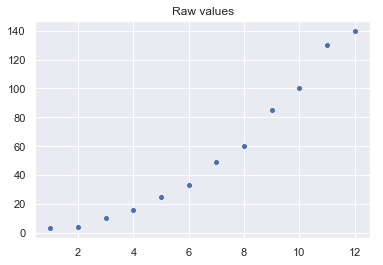

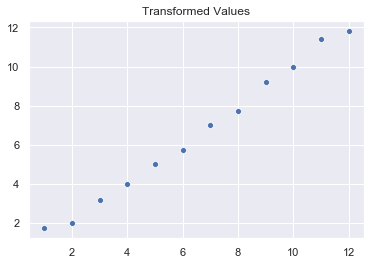

In [53]:
# Sample data.
outcome = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
feature = [3, 4, 10, 16, 25, 33, 49, 60, 85, 100, 130, 140]

# Plot the data as-is. Looks a mite quadratic.
sns.scatterplot(outcome, feature)
plt.title('Raw values')
plt.show()

# Create a feature using a non-linear transformation
sqrt_feature = [math.sqrt(x) for x in feature]

sns.scatterplot(outcome, sqrt_feature)
plt.title('Transformed Values')
plt.show()

## Assumption Two: Multivariate Normality

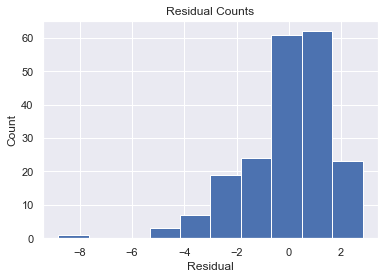

In [54]:
# Extract predicted values
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, aka "Residual"
residual = actual - predicted

# Plot it
plt.hist(residual)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

## Assumption Three: Homoscedasticity

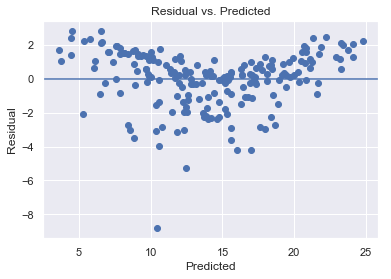

In [55]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

## Assumption Four: Low Multicollinearity

In [56]:
correlation_matrix = X.corr()
display(correlation_matrix)

,TV,Radio,Newspaper
TV,1.000,0.055,0.057
Radio,0.055,1.000,0.354
Newspaper,0.057,0.354,1.000


Let's see if we can make some changes to the data to convert it into a more normal distribution.

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


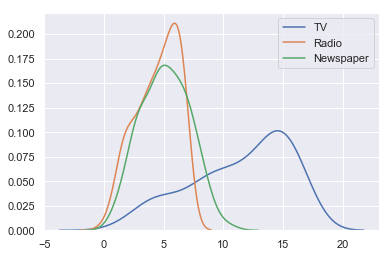

In [57]:
# Plot the square root of each data feature to see how that looks

sns.kdeplot(data['TV'] ** .5)
sns.kdeplot(data['Radio'] ** .5)
sns.kdeplot(data['Newspaper'] ** .5)
plt.show()

It looks a bit better. Let's see how it plays out.

In [58]:
# Make new features using the values we just plotted.
data['Newspaper SqRt'] = data['Newspaper'] ** (1/2)
data['TV SqRt'] = data['TV'] ** (1/2)
data['Radio SqRt'] = data['Radio'] ** (1/2)

# Create a new regression model
X2 = data[['TV SqRt', 'Radio SqRt', 'Newspaper SqRt']]
regr.fit(X2, Y)

# Inspect the results
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-Squared:\n')
print(regr.score(X2, Y))


Coefficients: 
 [[0.96780469 1.55683139 0.04403645]]

Intercept: 
 [-4.22436341]

R-Squared:

0.9083730830119968


Some changes happened. Let's see if the residuals are normally distributed.

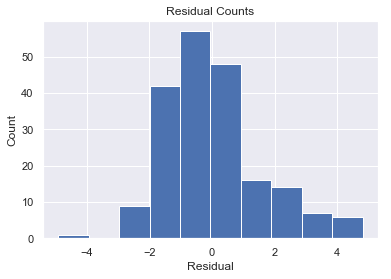

In [59]:
# Extract predicted values
predicted2 = regr.predict(X2).ravel()
actual = data['Sales']

# Calculate the error, aka "Residual"
residual2 = actual - predicted2

# Plot it
plt.hist(residual2)
plt.title('Residual Counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [60]:
# Test to see if the data is normally distributed.

print('Residual:')
normal_test(residual2)

Residual:
p = 0.000144839
Probably not a normal distribution


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


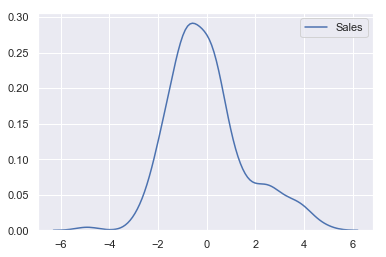

In [61]:
sns.kdeplot(residual2)

It looks more normal than before but running the normal test shows that it apparently is not. Now let's see how the scedasticity is effected.

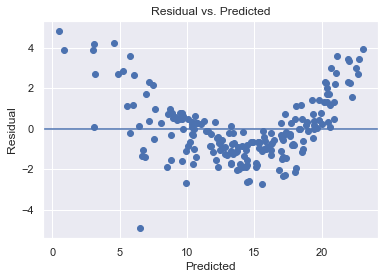

In [62]:
# Create a scatterplot of scedasticity
plt.scatter(predicted2, residual2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

While the distribution did become somewhat more normal, it seems to have made the scedasticity even worse. 